
## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
def _ncvar_to_dict(ncvar):
    """ Convert a NetCDF Dataset variable to a dictionary. """
    # copy all attribute except for scaling parameters
    d = dict((k, getattr(ncvar, k)) for k in ncvar.ncattrs()
             if k not in ['scale_factor', 'add_offset'])
    d['data'] = ncvar[:].T  # Data originally stored as (gate, azimuth)
    if np.isscalar(d['data']):
        # netCDF4 1.1.0+ returns a scalar for 0-dim array, we always want
        # 1-dim+ arrays with a valid shape.
        d['data'] = np.array(d['data'])
        d['data'].shape = (1, )
    return ds

In [84]:
%%writefile load_mrms_ppi.py

import netCDF4 as ncdf
import os
import pyart
import numpy as np
import matplotlib.pyplot as plt
import cartopy
from pyart.io.common import make_time_unit_str
import datetime
from pyart.config import FileMetadata
from pyart.config import get_metadata, get_fillvalue
from pyart.core.radar import Radar

def load_mrms_ppi(fdict, **kwargs):
    """
    Read multiple field sweeps from an MRMS radar file NetCDF file.
    
    Input parameters
    ----------------
    fdict : (list)  --> list of dicts [{file: file1, ncvar: "Reflectivity", pvar: "reflecitity"},
                                       {file: file2, ncvar: "Velocity",     pvar: "corrected_velocity"}]
               
       filename : (str) --> name of netCDF MRMS file to read from
       ncvar :    (str) --> name of variable to read from that file
       pvar :     (str) --> mapped name of ncvar into pyART
    
    Returns
    -------
    radar : Radar  --> pyArt radar object
    
    TODO:  For a given set of tilts, all the tilts will be set to the smallest number of gates in the
           tilts.  The data structure is not quite correct.

    """
    
    _debug = 0

    # Loop over files to find the dimensions of the data.
    
    n_gates = [1192]  # choose this to be the maximum number of gates we ever need.
    n_rays  = []
    n_elev  = []
    gates   = []
    
    for n, d in enumerate(fdict):
        
        try:
            ncfile = ncdf.Dataset(d['file'])
        except IOError:
            print('LOAD_PPI cannot open netCDF file: ', d['file'])
            break
            
        n_gates.append(len(ncfile.dimensions['Gate']))
        n_rays.append(len(ncfile.dimensions['Azimuth']))
        n_elev.append(ncfile.Elevation)
                
        ncfile.close()  # important to do this.
        
    _mygate = min(n_gates)

    if _debug > 0:
        print(n_gates)
        print('LOAD_PPI --> Number of files to read: %d' % len(fdict))
        print('LOAD_PPI --> _mygate: %d' % _mygate)
        
    # if we get this far, go ahead get to creating the radar object
    
    # this does not do anything yet except uses the object to create other objects
    # the default configuration is cfradial - for later.
    
    filemetadata = FileMetadata('cfradial')  

    # create all the objects needed below
    
    _latitude              = filemetadata('latitude')
    _longitude             = filemetadata('longitude')
    _altitude              = filemetadata('altitude')
    _metadata              = filemetadata('metadata')
    _sweep_start_ray_index = filemetadata('sweep_start_ray_index')
    _sweep_end_ray_index   = filemetadata('sweep_end_ray_index')
    _sweep_number          = filemetadata('sweep_number')
    
    _sweep_mode            = filemetadata('sweep_mode')
    _fixed_angle           = filemetadata('fixed_angle')
    _time                  = filemetadata('time')
    _elevation             = filemetadata('elevation')
    _azimuth               = filemetadata('azimuth')
    _range                 = filemetadata('range')
    
    _scan_type             = 'other'
    
    _fields                = {}  # dict to hold data

    # loop through files..

    for n, d in enumerate(fdict):

        ncfile                     = ncdf.Dataset(d['file'])
        pvar                       = d['pvar']
        ncvar                      = d['ncvar']
                      
        gwidth                     = ncfile.variables['GateWidth'][:].mean()        

        if n == 0:  # do these things once
            
            start_time                     = datetime.datetime.utcfromtimestamp(ncfile.Time)
            _time['data']                  = np.array([ncfile.FractionalTime][:])
            _time['units']                 = make_time_unit_str(start_time)

            _latitude['data']              = np.array(ncfile.Latitude)
            _longitude['data']             = np.array(ncfile.Longitude)
            _altitude['data']              = np.array([ncfile.Height], 'float64')
            
            _range['data']                 = ncfile.RangeToFirstGate + ncfile.variables['GateWidth'][0] \
                                           * (np.arange(_mygate-1) + 0.5)
            _sweep_mode['data']            = np.array(['ppi'])
            _azimuth['data']               = np.array(ncfile.variables['Azimuth'][:])
            _fixed_angle['data']           = np.array(n_elev)
            _elevation['data']             = np.array(n_rays[n]*[n_elev[n]])

            _sweep_number['data']          = np.arange(len(fdict), dtype='int32')
            _sweep_start_ray_index['data'] = np.cumsum(np.append([0], n_rays[:-1]).astype('int32'))
            _sweep_end_ray_index['data']   = np.cumsum(n_rays).astype('int32') - 1

            # copy meta data once

            metadata_mapping = {
                                'vcp-value': 'vcp-value',
                                'radarName-value': 'instrument_name',
                                }

            for netcdf_attr, metadata_key in metadata_mapping.items():
                if netcdf_attr in ncfile.ncattrs():
                    print(metadata_key, ncfile.getncattr(netcdf_attr))
                    _metadata[metadata_key] = ncfile.getncattr(netcdf_attr)
  
        # Okay do the big stuff.
 
        _dict         = get_metadata(pvar)
        _dict['data'] = np.ma.array(ncfile.variables[ncvar][:,0:_mygate-1])
            
        if 'MissingData' in ncfile.ncattrs():
            _dict['data'][_dict['data'] == ncfile.MissingData] = np.ma.masked
        if 'RangeFolded' in ncfile.ncattrs():
            _dict['data'][_dict['data'] == ncfile.RangeFolded] = np.ma.masked
            
        _dict['units'] = ncfile.getncattr('Unit-value')

        if _debug > 299:
            print(ncfile.variables[ncvar][:,0:_mygate-1].shape)
            print(_dict['data'].shape)

        _fields[pvar] = _dict
 
    # With elevation and azimuth in the radar object, lets recalculate
    # gate latitude, longitude and altitude,

    if _debug > 0:
        print('LOAD_PPI:  Volume mean time:  ',start_time)
    
    if _debug > 100:
        print('LOAD_PPI: final field dictionary: \n', _fields)
        print('LOAD_PPI: ngates.shape: ', _range['data'].shape)
        print('LOAD_PPI: nrays.shape: ', _azimuth['data'].shape)
        print('LOAD_PPI: sweep_start/stop: ', _sweep_start_ray_index['data'], _sweep_end_ray_index['data'])
        print('LOAD_PPI: sweeps: ', _sweep_number['data'])
    
    return Radar( _time, _range, _fields, _metadata, _scan_type,                    \
                  _latitude, _longitude, _altitude,                                 \
                  _sweep_number, _sweep_mode, _fixed_angle, _sweep_start_ray_index, \
                  _sweep_end_ray_index,                                             \
                  _azimuth, _elevation, instrument_parameters=None)

Overwriting load_mrms_ppi.py


In [87]:
%%writefile testppi.py

fdict = [{'file': './20200302/KOHX/Velocity/00.50/20200303-060515.netcdf', 'ncvar': 'Velocity', 'pvar': 'corrected_velocity'},
         {'file': './20200302/KOHX/Reflectivity/00.50/20200303-060458.netcdf', 'ncvar': 'ReflectivityQC', 'pvar': "reflectivity"}]

fdict = [{'file': './20200302/KOHX/Velocity/04.00/20200303-060220.netcdf', 'ncvar': 'Velocity', 'pvar': 'corrected_velocity'},
         {'file': './20200302/KOHX/Reflectivity/04.00/20200303-060220.netcdf', 'ncvar': 'ReflectivityQC', 'pvar': "reflectivity"}]


myradar = load_ppi(fdict)
myradar.init_gate_altitude()
myradar.init_gate_longitude_latitude()

#pyart.io.write_cfradial("test.nc", myradar,  format='NETCDF4')

Writing testppi.py


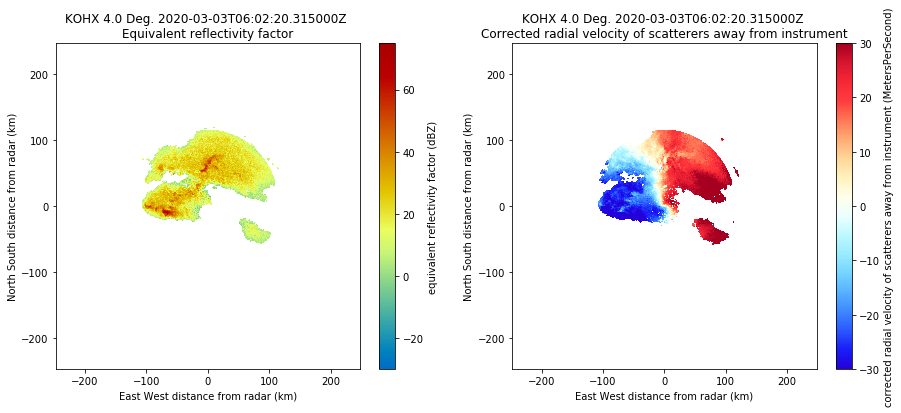

In [65]:
fig = plt.figure(figsize=(15,6))
display = pyart.graph.RadarMapDisplay(myradar)
plt.subplot(121)
display.plot_ppi('reflectivity')
plt.subplot(122)
display.plot_ppi('corrected_velocity')
plt.show()

In [66]:
min([721, 322, 1003])

322